In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#from platform import python_version
#python_version()

In [3]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [4]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'Berkeley_22'

## Getting RA&DEC from Bica 2019

In [5]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]
ra, dec

(89.61667, 7.75306)

## Querying the data

In [6]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [7]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [8]:
query = """SELECT 
ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.2))'

In [9]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
data = job.get_results()
len(data)

4615

In [11]:
#data

## Converting to pandas

In [12]:
df = data.to_pandas()
df

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
0,89.539094,7.574778,0.156728,0.166739,-1.064084,0.144468,1.373198,18.245781,0.332180,0.195325,NaN,NaN,200.001774,-8.230311
1,89.531008,7.572184,0.682760,0.125620,0.519465,0.099290,1.319292,17.651823,0.024297,0.119766,NaN,NaN,200.000147,-8.238581
2,89.527442,7.574768,-0.251459,0.138361,0.317865,0.109922,1.213259,17.911854,-0.023870,0.139842,NaN,NaN,199.996134,-8.240423
3,89.527865,7.584721,0.249076,0.253468,0.602991,0.199957,1.375969,18.812523,-0.181985,0.260510,NaN,NaN,199.987540,-8.235239
4,89.525980,7.580249,9.190094,0.555262,-5.126469,0.446584,1.998135,19.921804,0.296096,0.580148,NaN,NaN,199.990579,-8.239039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4610,89.651633,7.946369,-1.178740,0.726116,-0.214540,0.566001,1.515699,20.133791,-0.049194,0.577805,NaN,NaN,199.727913,-7.952823
4611,89.652776,7.945998,0.052393,0.021042,0.611883,0.016997,1.669723,14.092081,0.242862,0.020449,58.424332,2.675294,199.728795,-7.952012
4612,89.640721,7.948524,1.752863,0.224389,-8.862609,0.170935,1.901716,18.569071,0.695436,0.184674,NaN,NaN,199.720724,-7.961234
4613,89.638493,7.948408,-0.079136,0.521891,-3.412318,0.417366,2.079355,19.794733,0.543867,0.441877,NaN,NaN,199.719747,-7.963220


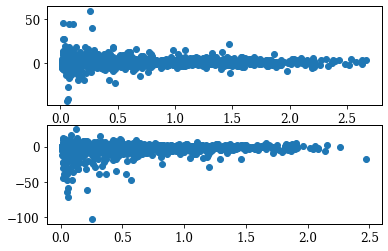

In [13]:
fig, ax = plt.subplots(2)

ax[0].scatter(df.pmra_error,df.pmra)
ax[1].scatter(df.pmdec_error,df.pmdec)

In [14]:
print(np.mean(df.pmdec), np.mean(df.pmdec_error)) ## por que pmra tem um erro muito maior?
print(np.mean(df.pmra), np.mean(df.pmra_error))

-1.5905380820608712 0.38736283779144287
0.6646265814889444 0.47623249888420105


## Applying better conditions to the variables

In [15]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(1590, 4615)

## Dropping uknown values of pmra, pmdec or parallax.

In [16]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmdec', 'parallax'])
ndf

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
7,89.524974,7.577343,0.402748,0.046084,-2.041744,0.035936,1.738115,15.840648,0.244742,0.048827,NaN,NaN,199.992660,-8.241318
8,89.522642,7.579380,0.502705,0.074220,-2.592697,0.057503,1.467915,16.773617,0.406603,0.072677,NaN,NaN,199.989729,-8.242355
9,89.509032,7.584008,-0.437887,0.201893,1.072672,0.168701,1.442408,18.691771,0.514329,0.214470,NaN,NaN,199.979038,-8.251919
17,89.503815,7.589471,-0.218250,0.041479,-0.403992,0.033457,1.816270,15.687636,0.116115,0.041967,NaN,NaN,199.971678,-8.253799
23,89.494603,7.600012,1.501835,0.104734,2.237526,0.084600,1.437773,17.467995,0.515311,0.107633,NaN,NaN,199.957891,-8.256685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,89.540160,7.925838,8.770818,0.086862,-14.153279,0.069121,1.313459,17.136509,0.380677,0.077413,NaN,NaN,199.692029,-8.059350
4605,89.564554,7.942680,10.761483,0.225860,-4.471689,0.187450,2.077412,18.602821,1.037440,0.189880,NaN,NaN,199.688977,-8.030054
4608,89.644552,7.947400,8.831797,0.083568,-7.766192,0.069201,2.339703,17.063850,3.008707,0.076475,NaN,NaN,199.723572,-7.958459
4611,89.652776,7.945998,0.052393,0.021042,0.611883,0.016997,1.669723,14.092081,0.242862,0.020449,58.424332,2.675294,199.728795,-7.952012


In [17]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler

## Creating the arrays to perform the 5-D HDBSCAN fit

In [18]:
X = np.dstack((ndf['pmra'],ndf['pmdec']))[0]
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

In [19]:
sc = StandardScaler()

escalada = sc.fit_transform(cincoD)

## Performing the HDBSCAN

In [20]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 551
Estimated no. points clustered: 558


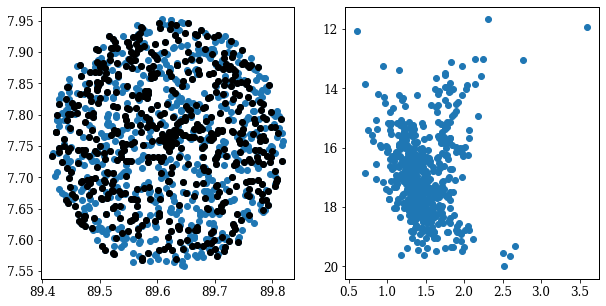

In [21]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples = 1, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(cincoD)

labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


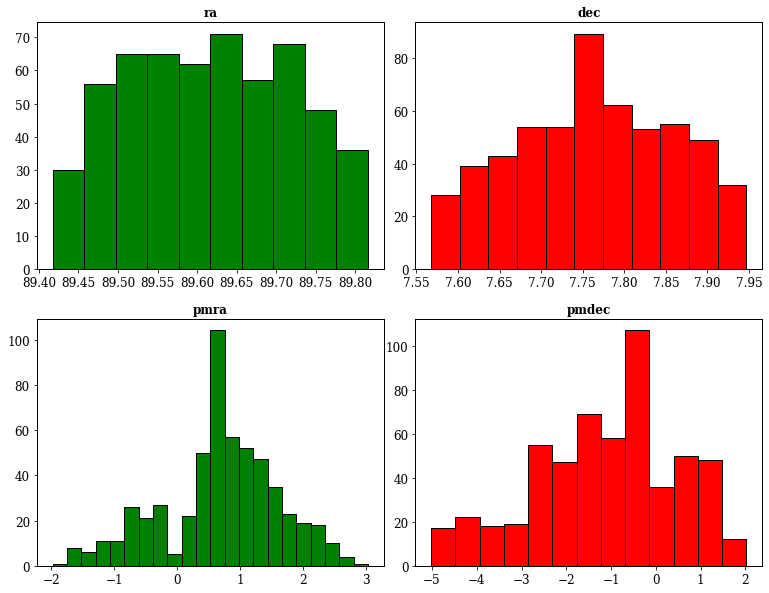

In [22]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


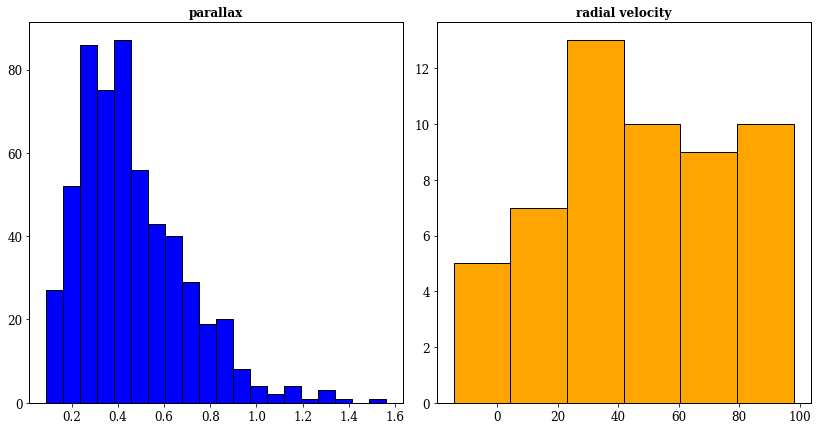

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Constructing a RDP and histograms of the clusters parameters

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

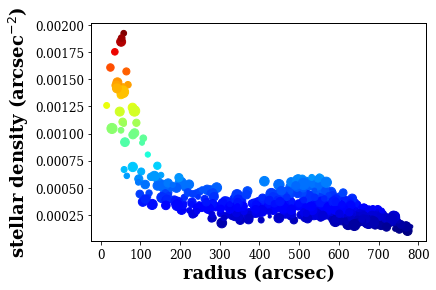

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=subset['ra']*units.degree, dec=subset['dec']*units.degree, frame='fk5')

nstar = len(subset)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([subset['ra']*np.cos(subset['dec']*np.pi/180.0), subset['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(subset['ra'], weights=den_data)
std_x = np.average((subset['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(subset['dec'], weights=den_data)
std_y = np.average((subset['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



## Gaussian fit

In [25]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 20
    # variables        = 3
    chi-square         = 1121.52192
    reduced chi-square = 65.9718774
    Akaike info crit   = 86.5341924
    Bayesian info crit = 89.5213893
[[Variables]]
    amplitude:  45.0426526 +/- 2.97863428 (6.61%) (init = 40.40236)
    center:     0.35812488 +/- 0.01686308 (4.71%) (init = 0.3222008)
    sigma:      0.23023357 +/- 0.01888666 (8.20%) (init = 0.1547983)
    fwhm:       0.54215861 +/- 0.04447468 (8.20%) == '2.3548200*sigma'
    height:     78.0486514 +/- 4.50014993 (5.77%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.717
    C(center, sigma)     = -0.298
    C(amplitude, center) = -0.262


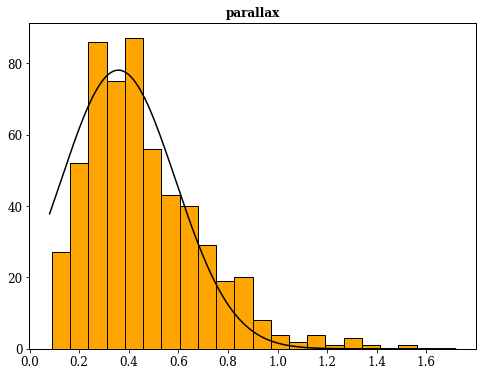

In [26]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 10
    # variables        = 3
    chi-square         = 402.743401
    reduced chi-square = 57.5347716
    Akaike info crit   = 42.9571454
    Bayesian info crit = 43.8649007
[[Variables]]
    amplitude:  32.0207840 +/- 2.89168771 (9.03%) (init = 16.33626)
    center:     89.6151744 +/- 0.01357631 (0.02%) (init = 89.59454)
    sigma:      0.18384871 +/- 0.02176793 (11.84%) (init = 0.1328151)
    fwhm:       0.43293061 +/- 0.05125956 (11.84%) == '2.3548200*sigma'
    height:     69.4834648 +/- 3.96545144 (5.71%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.885


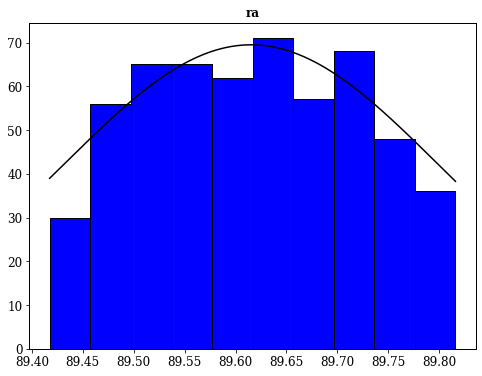

In [27]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 22
    # variables        = 3
    chi-square         = 3923.85989
    reduced chi-square = 206.518941
    Akaike info crit   = 120.043351
    Bayesian info crit = 123.316478
[[Variables]]
    amplitude:  119.464954 +/- 13.9261654 (11.66%) (init = 257.9887)
    center:     0.84900943 +/- 0.09959221 (11.73%) (init = 0.6438053)
    sigma:      0.73996309 +/- 0.09963626 (13.47%) (init = 0.8349149)
    fwhm:       1.74247989 +/- 0.23462545 (13.47%) == '2.3548200*sigma'
    height:     64.4081091 +/- 7.50778408 (11.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.578


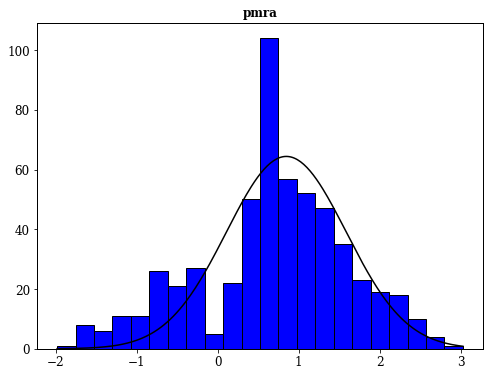

In [28]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 11
    # variables        = 3
    chi-square         = 723.464383
    reduced chi-square = 90.4330479
    Akaike info crit   = 52.0477165
    Bayesian info crit = 53.2414023
[[Variables]]
    amplitude:  25.1802383 +/- 2.34940036 (9.33%) (init = 11.57202)
    center:     7.77166618 +/- 0.01318267 (0.17%) (init = 7.757281)
    sigma:      0.14827194 +/- 0.01815269 (12.24%) (init = 0.06323506)
    fwhm:       0.34915372 +/- 0.04274632 (12.24%) == '2.3548200*sigma'
    height:     67.7502595 +/- 4.87723800 (7.20%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.810
    C(center, sigma)     = 0.128
    C(amplitude, center) = 0.125


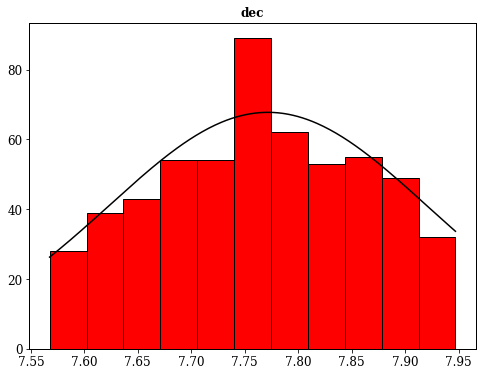

In [29]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 13
    # variables        = 3
    chi-square         = 3117.88070
    reduced chi-square = 311.788070
    Akaike info crit   = 77.2394726
    Bayesian info crit = 78.9343206
[[Variables]]
    amplitude:  341.153642 +/- 46.4616239 (13.62%) (init = 334.6972)
    center:    -0.79973053 +/- 0.28604289 (35.77%) (init = -0.3239796)
    sigma:      1.88431475 +/- 0.31439359 (16.68%) (init = 1.174376)
    fwhm:       4.43722206 +/- 0.74034032 (16.68%) == '2.3548200*sigma'
    height:     72.2281766 +/- 9.32340952 (12.91%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.654
    C(center, sigma)     = 0.127
    C(amplitude, center) = 0.102


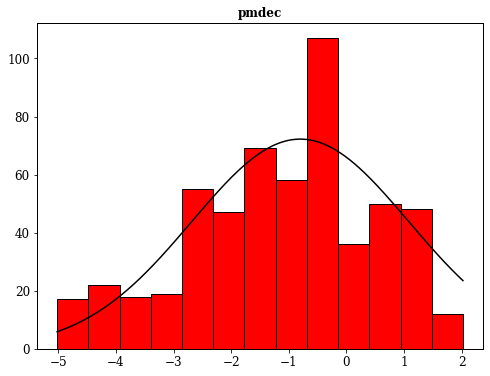

In [30]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 6
    # variables        = 3
    chi-square         = 14.8342290
    reduced chi-square = 4.94474300
    Akaike info crit   = 11.4310669
    Bayesian info crit = 10.8063453
[[Variables]]
    amplitude:  1661.98793 +/- 421.389004 (25.35%) (init = 808.1351)
    center:     56.6134414 +/- 12.5451822 (22.16%) (init = 60.58567)
    sigma:      59.5107134 +/- 18.9337810 (31.82%) (init = 33.6723)
    fwhm:       140.137018 +/- 44.5856463 (31.82%) == '2.3548200*sigma'
    height:     11.1414778 +/- 1.46611944 (13.16%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.919
    C(amplitude, center) = 0.521
    C(center, sigma)     = 0.499


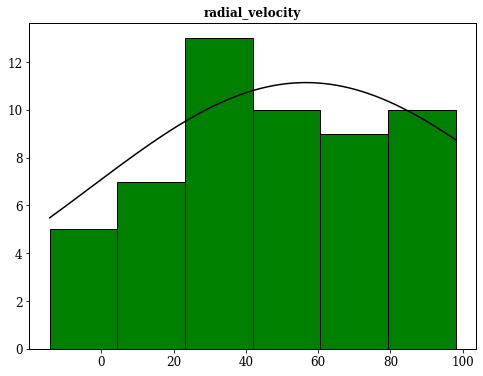

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

## Sigma Clipping

558
185


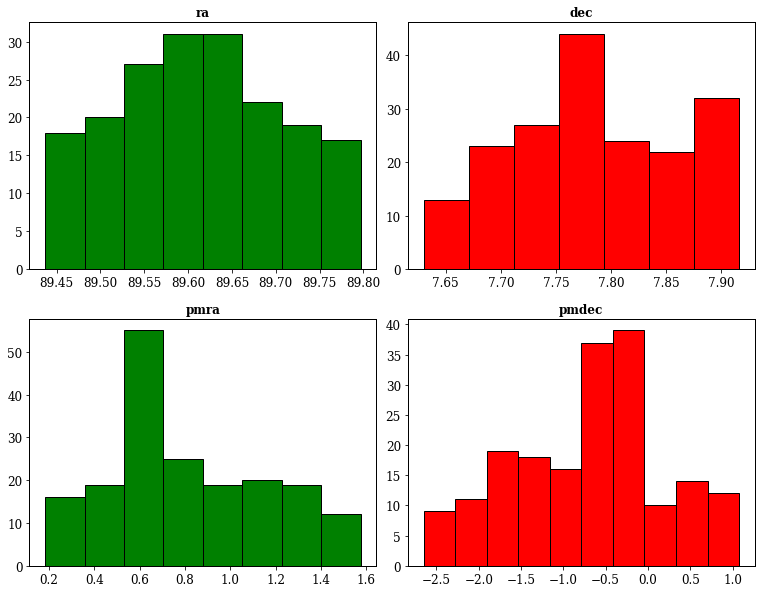

In [32]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


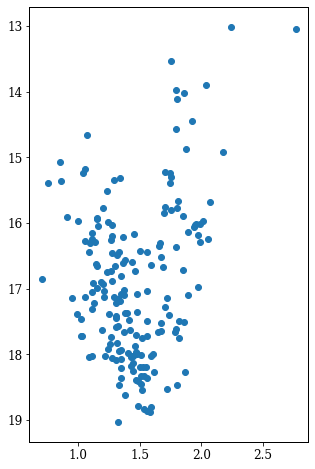

In [33]:
plt.figure(figsize=(5,8))
plt.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'])
plt.gca().invert_yaxis()

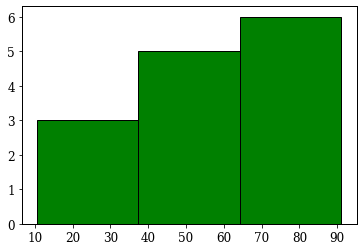

In [34]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']

plt.hist(data, optimal_bin, ec = 'k',color = 'green');

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

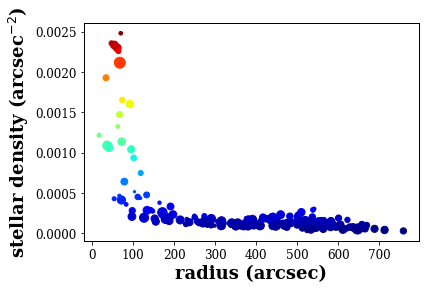

In [35]:
from astropy.coordinates import SkyCoord
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [36]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (89.61669972, 7.77554151)>

In [37]:
final = df.loc[(df.parallax < paralaxe_up ) & (df.parallax > paralaxe_down) & (df.ra>ra_down) & (df.ra<ra_up) & 
                              (df.dec>dec_down) & (df.dec<dec_up) & (df.pmra>pmra_down) & (df.pmra<pmra_up) & (df.pmdec>pmdec_down) 
                              & (df.pmdec<pmdec_up)  & (df.radial_velocity.isnull() | (df.radial_velocity>radvel_down) & (df.radial_velocity<radvel_up)) ]

In [38]:
clip_loop.to_csv('final_5d.csv', index=False)

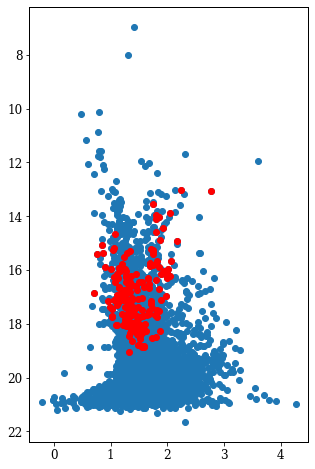

In [39]:
plt.figure(figsize=(5,8))
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'])
plt.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'red')
plt.gca().invert_yaxis()

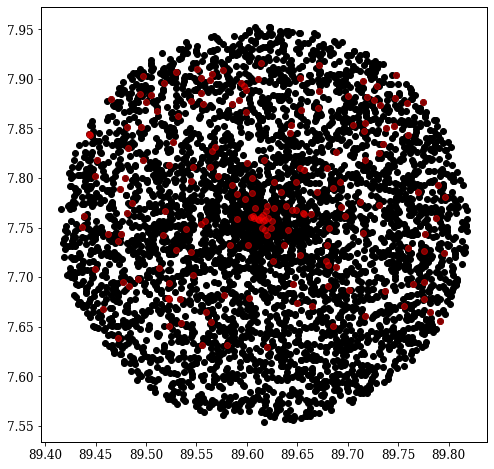

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(df['ra'],df['dec'], color = 'k')
plt.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', alpha = 0.5)